![EDA](https://snipboard.io/dPkXf1.jpg)

## **Análisis exploratorio (EDA) inversión de Criptomonedas**

### Nuestro proyecto se fundamenta en un análisis destinado a **inversiones a mediano y largo plazo**. Por consiguiente, no emplearemos datos OHLC (Open, High, Low, Close) ya que nuestra finalidad no se enfoca en operaciones de trading, sino en inversiones basadas en otros indicadores clave de `rendimiento (KPI) y objetivos`. Utilizaremos gráficas distintas a las velas para cumplir con nuestros objetivos de inversión.

In [1]:
%pip install pycoingecko

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, -1, Finished, Available)


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /nfs4/pyenv-bf92c85f-7c80-496b-8cba-6b96dc8f44eb/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SQLContext
from pycoingecko import CoinGeckoAPI
from pyspark.sql.types import *
from pyspark.sql.functions import col, max, last, avg, when
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 9, Finished, Available)

In [3]:
# Crear una cadena de conexión a Azure SQL
connection_string = "jdbc:sqlserver://server-cistelsa.database.windows.net:1433;databaseName=data-crypto;user=cistelsa;password=XXXXXXX"

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 10, Finished, Available)

In [4]:
# Conectarse a la base de datos y convertir cada tabla en dataframe spark
df_cryptocurrencies = spark.read.jdbc(connection_string, "cryptocurrencies")
df_bitcoin_halvings = spark.read.jdbc(connection_string, "bitcoin_halvings")
df_crypto_date = spark.read.jdbc(connection_string, "crypto_date")
df_crypto_dev = spark.read.jdbc(connection_string, "crypto_dev")
df_crypto_price = spark.read.jdbc(connection_string, "crypto_price")
df_crypto_social = spark.read.jdbc(connection_string, "crypto_social")

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 11, Finished, Available)

In [5]:
df_cryptocurrencies.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 12, Finished, Available)

+------------+------+------------+--------------------+------------------+------------+
|          id|symbol|        name|               image|      total_supply|  max_supply|
+------------+------+------------+--------------------+------------------+------------+
|    arbitrum|   arb|    Arbitrum|https://assets.co...|            1.0E10| 10000000000|
|     bitcoin|   btc|     Bitcoin|https://assets.co...|             2.1E7|    21000000|
|boba-network|  boba|Boba Network|https://assets.co...|             5.0E8|   500000000|
|elrond-erd-2|  egld|  MultiversX|https://assets.co...|       2.5860072E7|    31415926|
|    ethereum|   eth|    Ethereum|https://assets.co...|1.20211284999274E8|        null|
|gmd-protocol|   gmd|         GMD|https://assets.co...|           80000.0|       80000|
|         okb|   okb|         OKB|https://assets.co...|     2.359576853E8|   300000000|
|    optimism|    op|    Optimism|https://assets.co...|     4.294967296E9|  4294967296|
|      ripple|   xrp|         XR

### Realizamos una exploración profunda para poder extraer el suministro circulante de criptomonedas `circulating_supply` en forma de histórico, pero no fué posible ya que las APIs no suministran esta información específica, solo en tiempo real, es una data muy importante para la toma de decisiones y revisar que sucedió en el pasado, pero no vamos a frenar el proyecto por este inconveniente, lo tomaremos en tiempo real a continuación, aun así en el README.md va a quedar estipulado que nuestro proyecto sigue avanzando y tendrá actualizaciones dentro de las tareas a desarrollar está:
- ### La automatización del proceso de extracción en tiempo real a término indefinido incluyendo `circulating_supply`
- ### Investigación y búsqueda de la data histórica de cada criptomóneda del proyecto con relación a `circulating_supply`

In [6]:
# Declaro la función de la api de coingecko en una variable cg
cg = CoinGeckoAPI()

# Lista de las critomonedas seleccionadas para análisis
crypto_list = ['arbitrum', 'bitcoin', 'boba-network', 'elrond-erd-2', 'ethereum', 'gmd-protocol', 'okb', 'optimism', 'ripple', 'solana' ]

coin_market = cg.get_coins_markets(vs_currency='usd', ids=crypto_list)

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 13, Finished, Available)

In [7]:
# Creamos primero el esquema que va a tener nuestro dataframe en este caso solo 2 columnas
orderSchema = StructType([
    StructField("id", StringType()),
    StructField("circulating_supply", FloatType())
    ])

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 14, Finished, Available)

In [8]:
# Crear un DataFrame de Spark a partir de los datos de CoinGecko
df_spark_cp = spark.createDataFrame(coin_market, schema=orderSchema)

# Agregamos la columna de los datos al dataframe df_cryptocurrencies por medio de un join
df_cryptocurrencies = df_cryptocurrencies.join(df_spark_cp.select("id", "circulating_supply"), on="id", how="left")

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 15, Finished, Available)

In [9]:
df_cryptocurrencies.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 16, Finished, Available)

+------------+------+------------+--------------------+------------------+------------+------------------+
|          id|symbol|        name|               image|      total_supply|  max_supply|circulating_supply|
+------------+------+------------+--------------------+------------------+------------+------------------+
|      solana|   sol|      Solana|https://assets.co...|5.55286963547684E8|        null|       4.0802272E8|
|gmd-protocol|   gmd|         GMD|https://assets.co...|           80000.0|       80000|          59146.73|
|      ripple|   xrp|         XRP|https://assets.co...|   9.9988501123E10|100000000000|      5.2914192E10|
|boba-network|  boba|Boba Network|https://assets.co...|             5.0E8|   500000000|      3.42812544E8|
|     bitcoin|   btc|     Bitcoin|https://assets.co...|             2.1E7|    21000000|       1.9468768E7|
|    arbitrum|   arb|    Arbitrum|https://assets.co...|            1.0E10| 10000000000|      1.27500006E9|
|         okb|   okb|         OKB|htt

In [10]:
# Renombrar la columna en el DataFrame df_crypto_price
df_crypto_price = df_crypto_price.withColumnRenamed("cryptocurrency_id", "id")
# Agregamos la columna de los datos al dataframe df_crypto_price por medio de un join
df_crypto_price = df_crypto_price.join(df_cryptocurrencies.select("id", "max_supply", "circulating_supply"), on="id", how="left")

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 17, Finished, Available)

In [11]:
# Hacemos otro Join para agregarle la fecha de la data
df_crypto_price = df_crypto_price.join(df_crypto_date.select("date_id", "date"), on="date_id", how="left")

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 18, Finished, Available)

In [12]:
# hacemos un select para ver unicamente algunas columnas
new_crypto_price = df_crypto_price.select("id", "date", "price_usd", "market_cap_usd", "total_volume_usd", "max_supply", "circulating_supply")

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 19, Finished, Available)

In [13]:
new_crypto_price.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 20, Finished, Available)

+--------+----------+----------+--------------+----------------+----------+------------------+
|      id|      date| price_usd|market_cap_usd|total_volume_usd|max_supply|circulating_supply|
+--------+----------+----------+--------------+----------------+----------+------------------+
|ethereum|2015-08-07|2.83162000|             0|           90622|      null|      1.20216952E8|
|ethereum|2015-08-08|1.33075000|      80339475|          368070|      null|      1.20216952E8|
|ethereum|2015-08-10|0.68758571|      41556309|          400464|      null|      1.20216952E8|
|ethereum|2015-08-11|1.06737888|      64539006|         1518998|      null|      1.20216952E8|
|ethereum|2015-08-12|1.25661318|      76013261|         2073893|      null|      1.20216952E8|
|ethereum|2015-08-13|1.82539545|     110468836|         4380143|      null|      1.20216952E8|
|ethereum|2015-08-14|1.82597489|     110555313|         4355618|      null|      1.20216952E8|
|ethereum|2015-08-15|1.67094967|     101215246|   

In [14]:
# Obtener información sobre el tipo de dato de cada columna
new_crypto_price.dtypes

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 21, Finished, Available)

[('id', 'string'),
 ('date', 'date'),
 ('price_usd', 'decimal(18,8)'),
 ('market_cap_usd', 'bigint'),
 ('total_volume_usd', 'bigint'),
 ('max_supply', 'bigint'),
 ('circulating_supply', 'float')]

In [15]:
# Obtener información sobre el DataFrame
new_crypto_price.printSchema()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 22, Finished, Available)

root
 |-- id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- price_usd: decimal(18,8) (nullable = true)
 |-- market_cap_usd: long (nullable = true)
 |-- total_volume_usd: long (nullable = true)
 |-- max_supply: long (nullable = true)
 |-- circulating_supply: float (nullable = true)



In [16]:
# Resumen estadístico
new_crypto_price.describe().show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 23, Finished, Available)

+-------+--------+-----------------+--------------------+--------------------+--------------------+--------------------+
|summary|      id|        price_usd|      market_cap_usd|    total_volume_usd|          max_supply|  circulating_supply|
+-------+--------+-----------------+--------------------+--------------------+--------------------+--------------------+
|  count|   16073|            16073|               16071|               16073|               11917|               16073|
|   mean|    null|2986.602467262055|7.570971529962566E10| 5.456054508262365E9|3.108901471037828...|1.216394643907833...|
| stddev|    null|  9065.2933179227|1.777105882142119...|1.193410528980678...|4.590957482637237E10|2.213286402958035...|
|    min|arbitrum|       0.00268621|                   0|                   0|               80000|            59146.73|
|    max|  solana|   67617.01554486|       1278797895528|        178894068361|        100000000000|        5.2914192E10|
+-------+--------+--------------

### Es necesario tener el dato de la capitalización de mercado máxima de cada cryptomoneda y tener una referencia para tomar alguna decisión en un ciclo alsista este puede superarse multiplicado. Obviamente depende de la calidad del proyecto que está detras de la criptomoneda, también de la comunidad y por último que esta no tenga problemas legales o por la situación global entre en crisis y desaparezca.

In [17]:
marketCapMax = new_crypto_price.groupBy("id").agg(max("market_cap_usd").alias("MaximoMarket"))
marketCapMax.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 24, Finished, Available)

+------------+-------------+
|          id| MaximoMarket|
+------------+-------------+
|      solana|  77427308372|
|gmd-protocol|      8696350|
|      ripple| 131653046805|
|boba-network|    626008032|
|     bitcoin|1278797895528|
|    arbitrum|   2157934242|
|         okb|  14340743027|
|elrond-erd-2|   9812675698|
|    optimism|   1285982741|
|    ethereum| 571665766496|
+------------+-------------+



In [18]:
# Organizamos por fecha para beneficiarnos en la siguiente métrica
new_crypto_price= new_crypto_price.sort("date")
marketCapMaxLast = new_crypto_price.groupBy("id").agg(max("market_cap_usd").alias("MaxMarketCap"),last("market_cap_usd").alias("LastMarketCap"))
marketCapMaxLast.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 25, Finished, Available)

+------------+-------------+-------------+
|          id| MaxMarketCap|LastMarketCap|
+------------+-------------+-------------+
|      solana|  77427308372|   9300306072|
|gmd-protocol|      8696350|      3416498|
|      ripple| 131653046805|  31112167895|
|boba-network|    626008032|     44296575|
|     bitcoin|1278797895528| 559982624303|
|         okb|  14340743027|   2730544222|
|    arbitrum|   2157934242|   1335248416|
|elrond-erd-2|   9812675698|    740966252|
|    optimism|   1285982741|   1007166425|
|    ethereum| 571665766496| 217444475880|
+------------+-------------+-------------+



### En el siguiente dataFrame nos damos cuenta de qué porcentaje se afectó la capitalización de mercado por el ciclo bajista, esto es proporcianal al precio de la cryptomoneda. Por ejemplo **Bitcoin** bajó un **56%** respecto a su market cap máximo, esto indica que el precio tuvo el mismo comportamiento.

In [19]:
# Calcula el cambio absoluto en la capitalización del mercado
df_con_cambio = marketCapMaxLast.withColumn("CambioAbsoluto", col("MaxMarketCap") - col("LastMarketCap"))

# Calcula el porcentaje de cambio
df_con_porcentaje = df_con_cambio.withColumn("PorcentajeCambio", (col("CambioAbsoluto") / col("MaxMarketCap")) * 100)

# Selecciona las columnas relevantes
resultado = df_con_porcentaje.select("id", "MaxMarketCap", "LastMarketCap", "PorcentajeCambio")

# Ordenamos por PorcentajeCambio
resultado= resultado.sort("PorcentajeCambio", ascending=False)

# Muestra el resultado
resultado.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 26, Finished, Available)

+------------+-------------+-------------+------------------+
|          id| MaxMarketCap|LastMarketCap|  PorcentajeCambio|
+------------+-------------+-------------+------------------+
|boba-network|    626008032|     44296575| 92.92396059863974|
|elrond-erd-2|   9812675698|    740966252| 92.44888677864874|
|      solana|  77427308372|   9300306072| 87.98833865266681|
|         okb|  14340743027|   2730544222| 80.95953454532255|
|      ripple| 131653046805|  31112167895|  76.3680608614533|
|    ethereum| 571665766496| 217444475880| 61.96300554906124|
|gmd-protocol|      8696350|      3416498| 60.71342574758376|
|     bitcoin|1278797895528| 559982624303| 56.21023257378837|
|    arbitrum|   2157934242|   1335248416|38.123767165283255|
|    optimism|   1285982741|   1007166425|21.681186466249784|
+------------+-------------+-------------+------------------+



#### Segun los datos anteriores ☝️, tenemos resultados los cuales algunos preocupan un poco pero hablamos de criptomonedas y históricamente existen caidas del bitcoin de hasta el 88% y luego su perfecta recuperación, pero seleccionaremos las 4 primeras con mayor caida y analizaremos y estudiaremos a través de acontecimientos, noticias, desiciones corporativas y demás, es de tener en cuenta que a finales del año 2021 el mercado de cryptomonedas se vió afectado por la caida general comenzando su ciclo bajista afectando a todas las criptomonedas incluyendo las 4 siguientes:
### ![boba](https://assets.coingecko.com/coins/images/20285/thumb/BOBA.png?1636811576) **Boba Network (Boba)**: Su caida se debe a lo siguiente:
<br>

#### 1. Boba Network todavía está en desarrollo, y no ha logrado alcanzar un nivel de adopción significativo. Esto ha llevado a algunos inversores a perder la confianza en el proyecto.
<br>

#### 2. El airdrop de tokens BOBA. En noviembre de 2022, Boba Network realizó un airdrop de tokens BOBA a los titulares de tokens OMG. Esto provocó una venta masiva de tokens OMG, ya que algunos inversores vendieron sus tokens OMG para obtener tokens BOBA.
<br>

> ##### **Conclusión:** *Es una Criptomoneda de alto riesgo pero vale la pena correrlo ya que fué uno de los pioneros en implementar una blockchain de capa 2 para darle solución a las comisiones y velocidad en paralelo a la red de ethereum, las cuales serán una tendencia real en el próximo mercado alcista, la recuperación que tuvo en este 2023 fué muy favorable.*
<br>

### ![MultiversX](https://assets.coingecko.com/coins/images/12335/thumb/egld-token-logo.png?1673490885) **MultiversX (EGLD)**: Su caida se debe a lo siguiente:
<br>

#### 1. Es un Proyecto que cambió de nombre recientemente y se transformó en una plataforma de soluciones web 3 y el metaverso de crypto juegos el cual ha empezado a tener fuerza.
<br>

#### 2. Afectaciones en su plataforma han surgido y tiene muy grandes competidores, como descentraland, The Sandbox, Axie Infinity las cuales han sufrido grandes caidas.
<br>

> ##### **Conclusión:** *Es un proyecto muy favorable para el ecosistema de criptomonedas el cual va a seguir en tendencia en la siguiente temporada alsista dandole solución a plataformas de web 3 y el metaverso.*
<br>

### ![solana](https://assets.coingecko.com/coins/images/4128/thumb/solana.png?1640133422) **Solana (SOL)**: Su caida se debe a lo siguiente:
<br>

#### 1. Solana se vió muy afectada por la quiebra de la empresa de FTX la cual erá el segundo exchage más grande después de binance, esto llevó a una venta masiva y posterior caida de market cap.
<br>

#### 2. Una competencia muy amplia con blockchains de alto nivel como Cardano, Avalache, Ethereum y sus derivados  .
<br>

> ##### **Conclusión:** *Aunque es muy criticada por su gobernanza centralizada, en verdad es muy veloz y de comisiones bajas, está de seguro va estar dentro de las tendencias el próximo mercado alsista.*
<br>

### ![okb](https://assets.coingecko.com/coins/images/4463/thumb/WeChat_Image_20220118095654.png?1642471050) **OKB (OKB)**: Su caida se debe a lo siguiente:
<br>

#### 1. En realidad todos los golpes que han sufrido muchos exchange ultimamente afectando a los usuarios, muchos han optado por usar exchanges descentralizados, este tiene una variación es centralizado y descentralizado al mismo tiempo lo cual ha sido muy favorable y ubicarse en el segundo exchange más grande por lo cual a esta moneda no le ha afectado el market cap en el cliclo bajista .
<br>

> ##### **Conclusión:** *Existen problemas en la extracción de datos con la api de Coingecko ya que analizando la data original nos indica que el market cap ha bajado muy sustancialmente pero el precio ha subido, esto es un error, se verificó en la plataforma de coingecko y el historial de market cap de OKB es muy distinto al de la web Coinmarketcap por lo cual determinamos esta informaación como errada y le damos un punto positivo.*

##### **Se usó un logaritmo de extracción general para cada criptomoneda la unica forma para que se hallan cambiado los datos de esa forma es por errores en el dataset original en la plataforma de coingecko:**
```
# Lista de las critomonedas seleccionadas para análisis
crypto_list = ['bitcoin', 'ethereum', 'ripple', 'solana', 'okb', 'arbitrum', 'optimism', 'elrond-erd-2','boba-network', 'gmd-protocol']

# Definir las fechas de inicio y fin
start_date = pd.to_datetime("2013-04-28")
end_date = pd.to_datetime("2023-08-17")


# Crear un diccionario para almacenar los DataFrames de cada criptomoneda
crypto_dataframes = {}

# Realizar extracciones diarias limitadas a 25 por minuto para cada criptomoneda
for crypto in crypto_list:
    print(f"Procesando {crypto}...")
    current_date = start_date
    crypto_historical_data = []
    while current_date <= end_date:
        # Obtener el historial para la fecha actual
        data = cg.get_coin_history_by_id(id=crypto, date=current_date.strftime("%d-%m-%Y"), localization='false')
        # Agregar la fecha como una columna
        data['date'] = current_date
        # Agregar los datos a la lista
        crypto_historical_data.append(data)
        # Esperar 2.4 segundos
        time.sleep(1.8)
        # Avanzar a la siguiente fecha
        current_date += pd.DateOffset(days=1)
    
    # Convertir la lista de datos en un DataFrame
    crypto_df = pd.json_normalize(crypto_historical_data)
    crypto_dataframes[crypto] = crypto_df
    crypto_dataframes[crypto].to_csv("data/original/" + crypto + "_cg_full.csv", index=False)
```
<br>

### **Extraccion API de coingecko**
![Extraccion de coingecko](https://snipboard.io/BUnSmv.jpg)
<br>

### **OKB coingecko**
![OKB coingecko](https://snipboard.io/gJEqG1.jpg)
<br>

### **OKB coinmarketcap**
![OKB coinmarketcap](https://snipboard.io/Ips5AH.jpg)

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 27, Finished, Available)

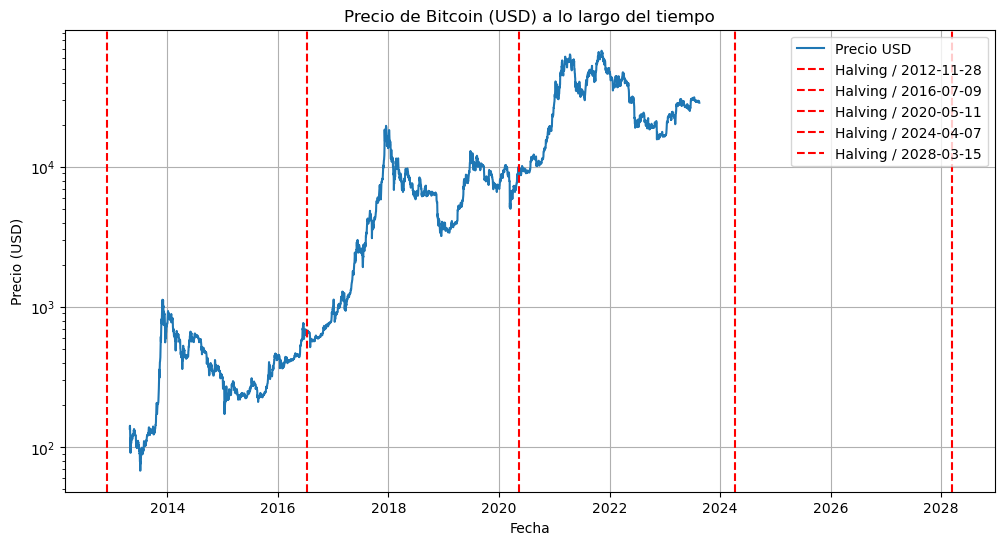

In [20]:
# Filtra datos para una criptomoneda específica (por ejemplo, Bitcoin)
bitcoin_data = new_crypto_price.filter(new_crypto_price["id"] == "bitcoin").select("date", "price_usd")

# Convierte el DataFrame de Spark en uno de Pandas para trazarlo con Matplotlib
bitcoin_data = bitcoin_data.toPandas()

# Graficar precios de Bitcoin a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["date"], bitcoin_data["price_usd"], label="Precio USD")
plt.title("Precio de Bitcoin (USD) a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
# Configurar el eje y en modo logarítmico
plt.yscale("log")
# Realiza un join con df_crypto_date para obtener las fechas de halving
bitcoin_halving_dates = (
    df_bitcoin_halvings
    .join(df_crypto_date, on="date_id", how="inner")
    .filter(df_bitcoin_halvings["cryptocurrency_id"] == "bitcoin")
    .select("date")
    .toPandas()
)
bitcoin_halving_dates = bitcoin_halving_dates.sort_values("date")
# Agrega líneas verticales entrecortadas para las fechas de halving
for halving_date in bitcoin_halving_dates["date"]:
    plt.axvline(x=halving_date, color='r', linestyle='--', label=f'Halving / {halving_date}')
plt.grid()
plt.legend()
plt.show()

### ☝️ Analizando el gráfico anterior podemos darnos cuenta que cada vez que ocurre el evento de halving de bitcoin, es una puerta muy grande para que el ciclo alsista comience, en este proyecto de inversión lo vamos a tener muy en cuenta, se aproxima uno de los eventos de halving para el proximo abril de 2024 y para esta fecha ya debemos tener la mayoría de la inversión acentada.

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 28, Finished, Available)

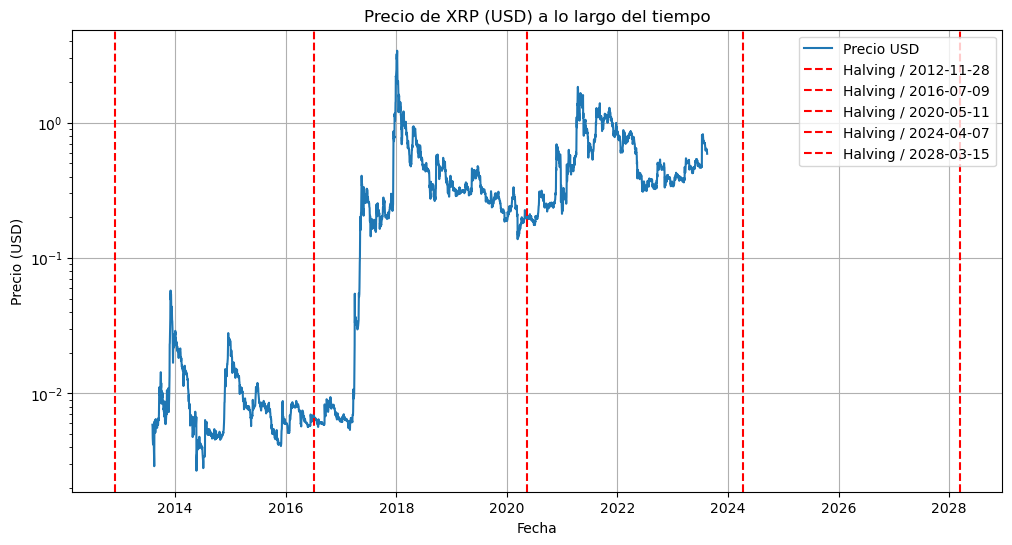

In [21]:
# Filtra datos para una criptomoneda específica (por ejemplo, Bitcoin)
bitcoin_data = new_crypto_price.filter(new_crypto_price["id"] == "ripple").select("date", "price_usd")

# Convierte el DataFrame de Spark en uno de Pandas para trazarlo con Matplotlib
bitcoin_data = bitcoin_data.toPandas()

# Graficar precios de Bitcoin a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["date"], bitcoin_data["price_usd"], label="Precio USD")
plt.title("Precio de XRP (USD) a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
# Configurar el eje y en modo logarítmico
plt.yscale("log")
# Realiza un join con df_crypto_date para obtener las fechas de halving
bitcoin_halving_dates = (
    df_bitcoin_halvings
    .join(df_crypto_date, on="date_id", how="inner")
    .filter(df_bitcoin_halvings["cryptocurrency_id"] == "bitcoin")
    .select("date")
    .toPandas()
)
bitcoin_halving_dates = bitcoin_halving_dates.sort_values("date")
# Agrega líneas verticales entrecortadas para las fechas de halving
for halving_date in bitcoin_halving_dates["date"]:
    plt.axvline(x=halving_date, color='r', linestyle='--', label=f'Halving / {halving_date}')
plt.grid()
plt.legend()
plt.show()

### ☝️ Ahora analicemos la criptomoneda XRP, podemos darnos cuenta que sucede exactamente lo mismo, pero a diferencia que en el ultimo halving ya ocurrido no pudo superar su máximo histórico, esto debido a una demanda de la SEC (Agencia Gubernamental y Federal encargada de regular los mercados financieros) por emisiones del token no soportadas, el resultado de esta demanda ya estuvo a favor de la cryptomoneda, por lo cual incrementó su valor en pleno ciclo bajista, esperamos mucho de XRP para el próximo ciclo alsista, no alcanzará a Ethereum por su sólido proyecto pero al ser usada en movimientos financieros bancarios muy importantes le espera un gran futuro.

### **Correlación de precios de Bitcoin y Ethereum**
#### Ethereum representa las denominadas Altcoins osea las alternativa a bitcoin en general, el movimiento de etehereum es el patron que siguen las demas cryptomonedas, aquí vamos a correlacionar ambas cryptos y veremos sus movimientos similares.

In [22]:
# Filtrar el DataFrame para incluir solo Bitcoin y Ethereum
bitcoin_ethereum_df = new_crypto_price.filter(new_crypto_price["id"].isin(["bitcoin", "ethereum"]))
# Agrupar los registros por 'date'
grouped_df = bitcoin_ethereum_df.groupBy("date")

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 29, Finished, Available)

#### Como tenemos más registros de Bitcoin que de Ethereum debemos nivelarlas y lo haremos por fecha `date` eliminaremos los registros más antiguos de Bitcoin hasta la fecha donde comienzan los registros de Ethereum, todo esto para que podamos generar una matriz de correlación.

In [23]:
# Cuenta los registros en cada grupo (fecha)
counts = grouped_df.count()
counts.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 30, Finished, Available)

+----------+-----+
|      date|count|
+----------+-----+
|2022-07-31|    2|
|2014-11-12|    1|
|2017-08-11|    2|
|2017-09-11|    2|
|2015-05-19|    1|
|2023-07-15|    2|
|2021-01-27|    2|
|2013-05-21|    1|
|2021-11-13|    2|
|2014-09-26|    1|
|2022-03-28|    2|
|2020-08-24|    2|
|2021-10-11|    2|
|2018-05-28|    2|
|2019-05-08|    2|
|2018-08-10|    2|
|2019-06-04|    2|
|2021-08-27|    2|
|2023-06-22|    2|
|2015-03-09|    1|
+----------+-----+
only showing top 20 rows



In [24]:
# Encuentra la fecha con el menor número de registros (para determinar cuántos registros eliminar)
min_count = counts.agg({"count": "min"}).collect()[0]["min(count)"]
print(min_count)

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 31, Finished, Available)

1


In [25]:
# Filtrar los registros de Bitcoin para igualar la cantidad de registros esto lo hacemos por min_count solo registros que tienen la fecha > a 1
bitcoin_filtered = bitcoin_ethereum_df.filter((col("id") == "bitcoin") & (col("date").isin(
    counts.filter(col("count") > min_count).select("date").rdd.flatMap(lambda x: x).collect()
)))

# Imprime el DataFrame filtrado
bitcoin_filtered.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 32, Finished, Available)

+-------+----------+------------+--------------+----------------+----------+------------------+
|     id|      date|   price_usd|market_cap_usd|total_volume_usd|max_supply|circulating_supply|
+-------+----------+------------+--------------+----------------+----------+------------------+
|bitcoin|2015-08-07|278.50881376|    4015651480|        47637462|  21000000|       1.9468768E7|
|bitcoin|2015-08-08|259.80072839|    3745910822|        80056217|  21000000|       1.9468768E7|
|bitcoin|2015-08-10|263.57820000|    3817350355|        60783290|  21000000|       1.9468768E7|
|bitcoin|2015-08-11|269.86680000|    3909600812|        64124893|  21000000|       1.9468768E7|
|bitcoin|2015-08-12|267.71260000|    3879202424|        73043602|  21000000|       1.9468768E7|
|bitcoin|2015-08-13|263.65581862|    3821420844|        57163447|  21000000|       1.9468768E7|
|bitcoin|2015-08-14|265.12810000|    3843674745|        61280619|  21000000|       1.9468768E7|
|bitcoin|2015-08-15|260.47623229|    377

In [26]:
# Lo mismo hacemos para Ethereum para estar seguros que no exista una registro de más.
ethereum_filtered = bitcoin_ethereum_df.filter((col("id") == "ethereum") & (col("date").isin(counts.filter(col("count") > min_count).rdd.map(lambda x: x["date"]).collect())))
ethereum_filtered.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 33, Finished, Available)

+--------+----------+----------+--------------+----------------+----------+------------------+
|      id|      date| price_usd|market_cap_usd|total_volume_usd|max_supply|circulating_supply|
+--------+----------+----------+--------------+----------------+----------+------------------+
|ethereum|2015-08-07|2.83162000|             0|           90622|      null|      1.20216952E8|
|ethereum|2015-08-08|1.33075000|      80339475|          368070|      null|      1.20216952E8|
|ethereum|2015-08-10|0.68758571|      41556309|          400464|      null|      1.20216952E8|
|ethereum|2015-08-11|1.06737888|      64539006|         1518998|      null|      1.20216952E8|
|ethereum|2015-08-12|1.25661318|      76013261|         2073893|      null|      1.20216952E8|
|ethereum|2015-08-13|1.82539545|     110468836|         4380143|      null|      1.20216952E8|
|ethereum|2015-08-14|1.82597489|     110555313|         4355618|      null|      1.20216952E8|
|ethereum|2015-08-15|1.67094967|     101215246|   

In [27]:
ethereum_filtered.describe().show()
bitcoin_filtered.describe().show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 34, Finished, Available)

+-------+--------+------------------+--------------------+--------------------+----------+------------------+
|summary|      id|         price_usd|      market_cap_usd|    total_volume_usd|max_supply|circulating_supply|
+-------+--------+------------------+--------------------+--------------------+----------+------------------+
|  count|    2932|              2932|                2931|                2932|         0|              2932|
|   mean|    null|  880.980794536954|1.021886563719317...| 9.332144105748295E9|      null|      1.20216952E8|
| stddev|    null|1095.1228650943033|1.306396963324825...|1.236711130839547...|      null|               0.0|
|    min|ethereum|        0.43297860|                   0|               87075|      null|      1.20216952E8|
|    max|ethereum|     4815.00463432|        571665766496|        140906534191|      null|      1.20216952E8|
+-------+--------+------------------+--------------------+--------------------+----------+------------------+

+-------+

In [28]:
# Seleccionamos las columnas que necesitamos para preparar los datos para la correlación de cada criptomoneda
bitcoin_price_usd = bitcoin_filtered.select("date", "price_usd").withColumnRenamed("price_usd", "price_bitcoin")
ethereum_price_usd = ethereum_filtered.select("date", "price_usd").withColumnRenamed("price_usd", "price_ethereum")

# Realiza una unión (join) utilizando la columna 'date' como clave de unión
bitcoin_ethereum_df = bitcoin_price_usd.join(ethereum_price_usd, "date", "inner")

# Selecciona solo las columnas necesarias
bitcoin_ethereum_corr = bitcoin_ethereum_df.select("date", "price_bitcoin", "price_ethereum")
# Organizamos las columnas por fecha
bitcoin_ethereum_corr = bitcoin_ethereum_corr.sort("date")
# Seleccionamos solo las columnas para la matriz
bitcoin_ethereum_corr = bitcoin_ethereum_corr.select("price_bitcoin", "price_ethereum")


# Convierte a Pandas para su análisis
bitcoin_ethereum_corr_df = bitcoin_ethereum_corr.toPandas()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 35, Finished, Available)

In [29]:
# Convertimos a tipo float para manejar la correlación
bitcoin_ethereum_corr_df[['price_bitcoin', 'price_ethereum']] = bitcoin_ethereum_corr_df[['price_bitcoin', 'price_ethereum']].round(8).astype('float')
bitcoin_ethereum_corr_df.info()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 36, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2932 entries, 0 to 2931
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_bitcoin   2932 non-null   float64
 1   price_ethereum  2932 non-null   float64
dtypes: float64(2)
memory usage: 45.9 KB


In [30]:
bitcoin_ethereum_corr_df.head()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 37, Finished, Available)

,price_bitcoin,price_ethereum
0,278.508814,2.831620
1,259.800728,1.330750
2,263.578200,0.687586
3,269.866800,1.067379
4,267.712600,1.256613


In [31]:
# Selecciona solo las columnas numéricas sobre las cuales deseas calcular la correlación
columns_for_correlation = ["price_bitcoin", "price_ethereum"]

# Calcula la matriz de correlación para las columnas seleccionadas
correlation_matrix = bitcoin_ethereum_corr_df[columns_for_correlation].corr()

# Imprime la matriz de correlación
print(correlation_matrix)

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 38, Finished, Available)

                price_bitcoin  price_ethereum
price_bitcoin        1.000000        0.939378
price_ethereum       0.939378        1.000000


StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 39, Finished, Available)

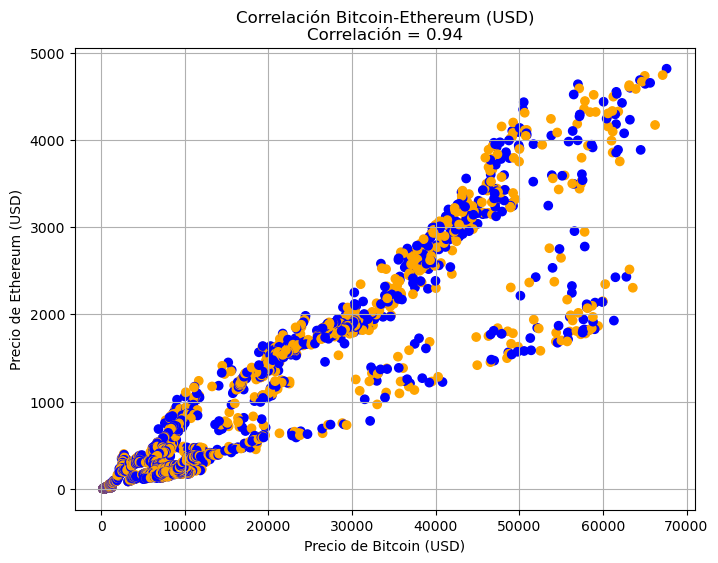

In [32]:
# Crear un gráfico de dispersión para visualizar la correlación
bitcoin_prices = bitcoin_price_usd.select("price_bitcoin").rdd.flatMap(lambda x: x)
ethereum_prices = ethereum_price_usd.select("price_ethereum").rdd.flatMap(lambda x: x)

# Definir colores para Bitcoin (naranja) y Ethereum (azul)
bitcoin_color = 'orange'
ethereum_color = 'blue'

plt.figure(figsize=(8, 6))
# Usar np.where para asignar colores de manera eficiente
colors = np.where(np.arange(len(bitcoin_prices.collect())) % 2 == 0, bitcoin_color, ethereum_color)

plt.scatter(bitcoin_prices.collect(), ethereum_prices.collect(), c=colors)
plt.title(f"Correlación Bitcoin-Ethereum (USD)\nCorrelación = {correlation_matrix.loc['price_bitcoin', 'price_ethereum']:.2f}")
plt.xlabel("Precio de Bitcoin (USD)")
plt.ylabel("Precio de Ethereum (USD)")
plt.grid(True)
plt.show()


### ☝️ Algo muy esperado la correlación de Bitcoin y Ethereum, nos deja varias conclusiones una de ellas es que podemos ver como se repite un patron y es cuando bitcoin sube de precio de forma natural ethereum lo sigue casi de forma inmediata, pero si bitcoin sube por fomo o por noticias impactantes, las inversiones se centran en bitcoin y ethereum baja, pero al pasar los días ethereum reacciona se recupera y sube mucho más porcentaje que bitcoin, esto mismo pasa en las demas cryptomonedas, pero hay que tener en cuenta que cuando baja el bitcoin todas bajan inmediatamente y proporcional a su subida la bajada es mucho mayor en porcentaje que bitcoin.

## **Mapa de correlación de las 10 criptomonedas**
#### Debemos nivelar todas las criptomonedas con los mismos datos de la cryptomoneda más joven en este caso `Arbitrum` la cual su data inició en el mes de marzo de 2023

In [33]:
# Agrupar los registros por 'date'
groupall_df = new_crypto_price.groupBy("date")

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 40, Finished, Available)

In [34]:
# Cuenta los registros en cada grupo (fecha)
counts_all = groupall_df.count()
counts_all.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 41, Finished, Available)

+----------+-----+
|      date|count|
+----------+-----+
|2022-07-31|    8|
|2014-11-12|    2|
|2017-08-11|    3|
|2017-09-11|    3|
|2015-05-19|    2|
|2023-07-15|   10|
|2021-01-27|    6|
|2013-05-21|    1|
|2021-11-13|    6|
|2014-09-26|    2|
|2022-03-28|    7|
|2020-08-24|    5|
|2021-10-11|    6|
|2018-05-28|    3|
|2019-05-08|    4|
|2018-08-10|    4|
|2019-06-04|    4|
|2021-08-27|    6|
|2023-06-22|   10|
|2015-03-09|    2|
+----------+-----+
only showing top 20 rows



In [35]:
def filter_crypto_by_count(crypto_df, crypto_id, min_count, counts_df):
    filtered_dates = counts_df.filter(col("count") > min_count).select("date").rdd.flatMap(lambda x: x).collect()
    filtered_crypto_df = crypto_df.filter((col("id") == crypto_id) & (col("date").isin(filtered_dates)))
    return filtered_crypto_df

# Definir el mínimo de registros deseados
min_count = 9

# Filtrar Bitcoin, Ethereum y Ripple usando la función
bitcoin_x_10 = filter_crypto_by_count(new_crypto_price, "bitcoin", min_count, counts_all)
ethereum_x_10 = filter_crypto_by_count(new_crypto_price, "ethereum", min_count, counts_all)
ripple_x_10 = filter_crypto_by_count(new_crypto_price, "ripple", min_count, counts_all)
solana_x_10 = filter_crypto_by_count(new_crypto_price, "solana", min_count, counts_all)
gmd_x_10 = filter_crypto_by_count(new_crypto_price, "gmd-protocol", min_count, counts_all)
boba_x_10 = filter_crypto_by_count(new_crypto_price, "boba-network", min_count, counts_all)
arbitrum_x_10 = filter_crypto_by_count(new_crypto_price, "arbitrum", min_count, counts_all)
okb_x_10 = filter_crypto_by_count(new_crypto_price, "okb", min_count, counts_all)
elrond_x_10 = filter_crypto_by_count(new_crypto_price, "elrond-erd-2", min_count, counts_all)
optimism_x_10 = filter_crypto_by_count(new_crypto_price, "optimism", min_count, counts_all)


# Imprime el DataFrame filtrado
bitcoin_x_10.show()

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 42, Finished, Available)

+-------+----------+--------------+--------------+----------------+----------+------------------+
|     id|      date|     price_usd|market_cap_usd|total_volume_usd|max_supply|circulating_supply|
+-------+----------+--------------+--------------+----------------+----------+------------------+
|bitcoin|2023-03-23|27449.25483081|  530515158754|     35394833934|  21000000|       1.9468768E7|
|bitcoin|2023-03-24|28459.73511355|  549578396179|     20360807195|  21000000|       1.9468768E7|
|bitcoin|2023-03-25|27595.49474838|  533634255119|     21551272690|  21000000|       1.9468768E7|
|bitcoin|2023-03-26|27670.19949850|  534960802333|     15053754845|  21000000|       1.9468768E7|
|bitcoin|2023-03-27|28048.46997853|  542675619059|     14450374261|  21000000|       1.9468768E7|
|bitcoin|2023-03-28|27182.29955995|  525230880103|     18519053232|  21000000|       1.9468768E7|
|bitcoin|2023-03-29|27291.35002105|  528042785009|     17658503319|  21000000|       1.9468768E7|
|bitcoin|2023-03-30|

In [36]:
def prepare_and_calculate_correlation(crypto_df, crypto_id, columns_for_correlation, columns_for_all_correlation,  all_crypto_df):
    # Selecciona las columnas necesarias y renómbralas
    price_columns = ["price_usd"]#[f"price_usd_{crypto_id}"]
    selected_columns = ["date"] + price_columns
    crypto_price_usd = crypto_df.select(*selected_columns).withColumnRenamed(price_columns[0], f"price_{crypto_id}")
    
    # Realiza join con 'all_crypto_df'
    if all_crypto_df is None:
        all_crypto_df = crypto_price_usd
    else:
        all_crypto_df = all_crypto_df.join(crypto_price_usd, "date", "inner")
    
    # Imprimir las columnas en 'all_crypto_df' después del join
    all_crypto_df.printSchema()

    num_columnas = len(all_crypto_df.columns)

    correlation_matrix = None
    
    if num_columnas == 11:
        # Selecciona solo las columnas necesarias para la correlación
        correlation_df = all_crypto_df
        
        # Ordena por fecha
        correlation_df = correlation_df.sort("date")
        
        # Convierte a Pandas para el cálculo de correlación
        correlation_pd_df = correlation_df.toPandas()
        
        # Convierte a tipo float
        correlation_pd_df[columns_for_all_correlation] = correlation_pd_df[columns_for_all_correlation].round(8).astype('float')
        
        # Calcula la matriz de correlación
        correlation_matrix = correlation_pd_df[columns_for_all_correlation].corr()
    
    return correlation_matrix, all_crypto_df

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 43, Finished, Available)

In [37]:
# Define las criptomonedas y columnas para correlación
cryptos = ["bitcoin", "ethereum", "ripple", "solana", "gmd", "boba", "arbitrum", "okb", "elrond", "optimism"]
columns_for_correlation_all = ["price_bitcoin", "price_ethereum", "price_ripple", "price_solana", "price_gmd", "price_boba", "price_arbitrum", "price_okb", "price_elrond", "price_optimism"]

# Crea una lista de DataFrames correspondiente a cada criptomoneda
crypto_dataframes = [bitcoin_x_10, ethereum_x_10, ripple_x_10, solana_x_10, gmd_x_10, boba_x_10, arbitrum_x_10, okb_x_10, elrond_x_10, optimism_x_10]

# Inicializa 'all_crypto_df' como None
all_crypto_df = None


# Calcula y muestra la matriz de correlación para cada criptomoneda
for i, crypto in enumerate(cryptos):
    correlation_matrix, all_crypto_df = prepare_and_calculate_correlation(crypto_dataframes[i], crypto, columns_for_correlation_all[i], columns_for_correlation_all, all_crypto_df)


StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 44, Finished, Available)

root
 |-- date: date (nullable = true)
 |-- price_bitcoin: decimal(18,8) (nullable = true)

root
 |-- date: date (nullable = true)
 |-- price_bitcoin: decimal(18,8) (nullable = true)
 |-- price_ethereum: decimal(18,8) (nullable = true)

root
 |-- date: date (nullable = true)
 |-- price_bitcoin: decimal(18,8) (nullable = true)
 |-- price_ethereum: decimal(18,8) (nullable = true)
 |-- price_ripple: decimal(18,8) (nullable = true)

root
 |-- date: date (nullable = true)
 |-- price_bitcoin: decimal(18,8) (nullable = true)
 |-- price_ethereum: decimal(18,8) (nullable = true)
 |-- price_ripple: decimal(18,8) (nullable = true)
 |-- price_solana: decimal(18,8) (nullable = true)

root
 |-- date: date (nullable = true)
 |-- price_bitcoin: decimal(18,8) (nullable = true)
 |-- price_ethereum: decimal(18,8) (nullable = true)
 |-- price_ripple: decimal(18,8) (nullable = true)
 |-- price_solana: decimal(18,8) (nullable = true)
 |-- price_gmd: decimal(18,8) (nullable = true)

root
 |-- date: date (nul

StatementMeta(, 15e3ccf3-e631-4887-950f-5932f0c85018, 64, Finished, Available)

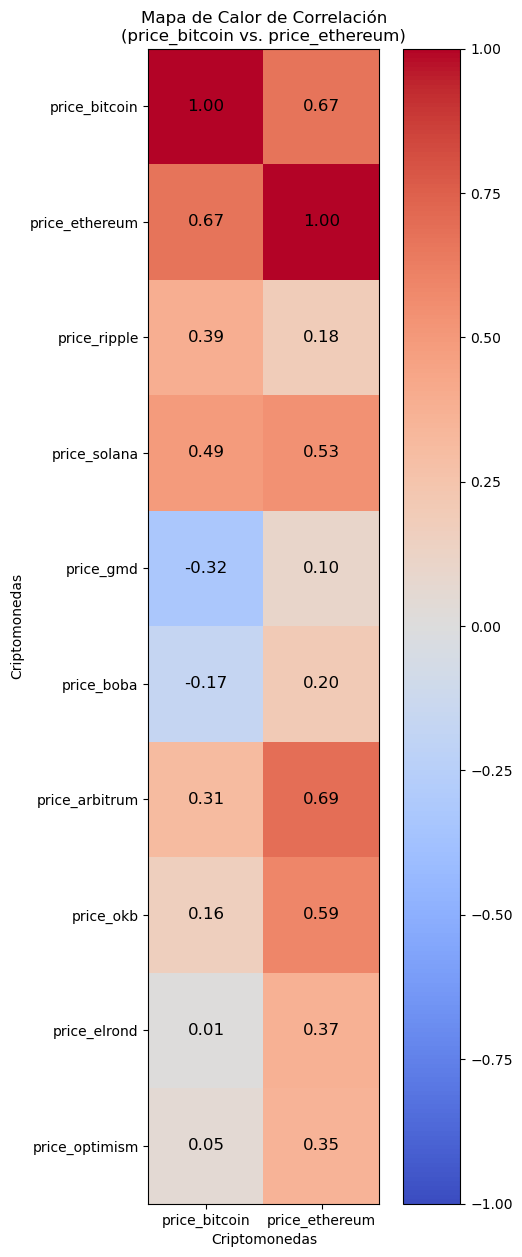

In [57]:
correlation_matrix = correlation_matrix.iloc[:10, :2]  # Selecciona las 2 primeras columnas y las 10 primeras filas

plt.figure(figsize=(6, 15))  # Establece el tamaño de la figura

# Utiliza 'imshow' para mostrar la matriz de correlación como un mapa de calor
cax = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Agrega las anotaciones
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)

# Ajusta el ancho de las celdas para que sean cuadradas
plt.gca().set_aspect('equal', adjustable='box')

# Añade etiquetas de los ejes
plt.xticks(np.arange(correlation_matrix.shape[1]), correlation_matrix.columns)
plt.yticks(np.arange(correlation_matrix.shape[0]), correlation_matrix.index)

# Añade etiquetas de los ejes y el título
plt.xlabel("Criptomonedas")
plt.ylabel("Criptomonedas")
plt.title("Mapa de Calor de Correlación\n(price_bitcoin vs. price_ethereum)")

# Muestra el mapa de calor
plt.colorbar(cax)
plt.show()

### ☝️ En este mapa de calor vemos correlaciones respecto al precio de Bitcoin y respeto a Ethereum, podemos analizar que hay cryptomonedas que se mueven muy diferente a bitcoin pero más similar a Ethereum, esto es muy normal ya que Ethereum es la representación de las Altcoin, nos damos cuenta que bitcoin es una guía a nivel general por sus ciclos alsistas, pero debemos revisar lo que pasa con Ethereum y nos daremos cuenta que se mueve similar a las otras crypto o mas bien viceversa, pero esto no es todo, debemos estar muy pendiente ya que puede tener muy poca correlación pero no significa que sea por un precio negativo, es el caso de `XRP` su movimiento ha sido positivo y por esta situación se aleja de la correlación, pero se ven casos negativos por ejemplo `Optimism` su valor ha ido decreciendo y la correlación alejando, por último vemos a GMD con una correlación baja pero ha sido por sus movimientos extremadamente volátiles pero se ha mantenido de forma paralela al BTC.

### **Conclusion final, estamos muy satisfechos con los analisis ya que nos ayuda a tomar decisiones para realizar una inversión a largo plazo, nos espera un buen futuro siguiendo el Halving de Bitcoin y retomando el analisis de la correlación de BTC y las demás cryptos <mark>nos damos cuenta que estamos diversificando la cartera de una forma muy óptima</mark>, <u>de nada sirve diversificar si todas se comportan igual</u>. ¡Te deseamos excelentes inversiones!**